In [1]:
import soundfile as sf
import os
import glob

In [2]:
inp_audio, _ = sf.read("/media/user/nvme/contrastive_experiments/experiments_audioset_v5_full/cnn12_1x_full_tr_8x128_Adam_1e-3_warmupcosine_wd0._fixed_lr_scaling_randomgain_gaussiannoise_timemask_bgnoise_nolineareval_full_ft_fullmodel_r2/inspection_all_maps_f/01/0000/input_audio/input_03.wav")
dec_audio, _ = sf.read("/media/user/nvme/contrastive_experiments/experiments_audioset_v5_full/cnn12_1x_full_tr_8x128_Adam_1e-3_warmupcosine_wd0._fixed_lr_scaling_randomgain_gaussiannoise_timemask_bgnoise_nolineareval_full_ft_fullmodel_r2/inspection_all_maps_f/01/0000/deconv_audio/deconv_03.wav")

In [3]:
import matplotlib.pyplot as plt

In [4]:
import IPython.display as ipd

In [5]:
import sys
sys.path.append("/home/user/Research/sonifications-paper1517/")
from src.utilities import fourier_analysis
from src.utilities import interpretability_utils

/home/user/miniconda3/envs/asr-env/lib/python3.8/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [6]:
EXP_DIR = "/media/user/nvme/contrastive_experiments/experiments_audioset_v5_full/cnn12_1x_full_tr_8x128_Adam_1e-3_warmupcosine_wd0._fixed_lr_scaling_randomgain_gaussiannoise_timemask_bgnoise_nolineareval_full_ft_fullmodel_r2"

In [7]:
res = interpretability_utils.prep_finetuned_model_and_decoder(EXP_DIR, last_epoch=50)

Loading /media/user/nvme/contrastive_experiments/experiments_audioset_v5_full/cnn12_1x_full_tr_8x128_Adam_1e-3_warmupcosine_wd0._fixed_lr_scaling_randomgain_gaussiannoise_timemask_bgnoise_nolineareval_full_ft_fullmodel_r2/ckpts/epoch=050_tr_loss=0.010282_tr_acc=0.548727_val_acc=0.322958.pth


In [8]:
model, net, deconv, hparams = res['full_model'], res['feature_extractor'], res['deconv_decoder'], res['hparams']

In [9]:
sys.path.append("/home/user/Research/signals/Tutorials/")
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import librosa
import random
import math
import makelab
from makelab import audio
from makelab import signal

In [10]:
def random_shift_signal(input_waveform):
    offset_len = random.randint(0, len(input_waveform)//2)
    inp_2 = np.append(np.zeros(offset_len, dtype=np.float32), inp_audio)[:-offset_len]
    return inp_2, offset_len

In [24]:
def get_correlation_and_shift(a, b):
    correlate_result = np.correlate(a, b, 'full')
    shift_positions = np.arange(-len(a) + 1, len(b))
    
    euclid_distance_a_to_b = distance.euclidean(a, b)
    best_correlation_index = np.argmax(correlate_result)
    shift_amount_debug = shift_positions[best_correlation_index]
    shift_amount = (-len(a) + 1) + best_correlation_index
    return correlate_result, euclid_distance_a_to_b, shift_positions, shift_amount, best_correlation_index

In [56]:
def plot_invariance(input_waveform, sonification, shifted_waveform, 
                    shifted_sonification, shift_offset, 
                    bshift_method = 'zero_fill', pad_function = None):
    orig_correlate_result, orig_euc_dist, orig_shift_pos, orig_shift_amt, orig_corr_index = get_correlation_and_shift(input_waveform, sonification)
    
    num_charts = 5
    chart_height = 3.6
    fig, axes = plt.subplots(num_charts, 1, figsize=(10, num_charts * chart_height))
    
    a_marker = None
    b_marker = None
    if len(input_waveform) < 50:
        a_marker = "o"
        b_marker = "D"
    
    axes[0].plot(input_waveform, alpha=0.7, label="Original Input", marker=a_marker)
    axes[0].plot(sonification, alpha=0.7, label="Original Sonification", marker=b_marker)
    axes[0].legend()
    axes[0].set_title(f"Raw Original Signals")
    
    axes[1].stem(orig_shift_pos, orig_correlate_result, use_line_collection=True, label="Cross-correlation of Original Input and Sonification")
    axes[1].set_title(f"Cross-correlation result | shift amount: {orig_shift_amt}")
    axes[1].set_ylabel("Cross Correlation")
    axes[1].set_xlabel("Sonification Signal Shift Amount")
    
    best_match_ymin = 0
    best_match_ymin_normalized = makelab.signal.map(best_match_ymin, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    best_match_ymax = orig_correlate_result[orig_corr_index]
    best_match_ymax_normalized = makelab.signal.map(best_match_ymax, axes[1].get_ylim()[0], axes[1].get_ylim()[1], 0, 1)
    axes[1].axvline(orig_shift_pos[orig_corr_index], ymin=best_match_ymin_normalized, ymax=best_match_ymax_normalized, 
                    linewidth=2, color='orange', alpha=0.8, linestyle='-.', 
                    label=f"Best match ({orig_shift_amt}, {best_match_ymax:.2f})")
    axes[1].legend()
    
    axes[2].plot(shifted_waveform, alpha=0.7, label="Input offset +{} steps".format(shift_offset), marker=a_marker)
    axes[2].plot(shifted_sonification, alpha=0.7, label="Sonification of offset input", marker=b_marker)
    axes[2].legend()
    axes[2].set_title(f"Raw Offset Signals")
    
    offset_correlate_result, _, offset_shift_pos, offset_shift_amt, offset_best_corr_index = get_correlation_and_shift(input_waveform, shifted_sonification)
    axes[3].stem(offset_shift_pos, offset_correlate_result, use_line_collection=True, label="Cross-correlation of Original Input with Offset Sonification")
    axes[3].set_title(f"Cross-correlation result | Required shift amount: {offset_shift_amt}")
    axes[3].set_ylabel("Cross Correlation")
    axes[3].set_xlabel("Sonification Signal Shift Amount")
    
    best_match_ymin = 0
    best_match_ymin_normalized = makelab.signal.map(best_match_ymin, axes[3].get_ylim()[0], axes[3].get_ylim()[1], 0, 1)
    best_match_ymax = offset_correlate_result[offset_best_corr_index]
    best_match_ymax_normalized = makelab.signal.map(best_match_ymax, axes[3].get_ylim()[0], axes[3].get_ylim()[1], 0, 1)
    axes[3].axvline(offset_shift_pos[offset_best_corr_index], ymin=best_match_ymin_normalized, ymax=best_match_ymax_normalized, 
                    linewidth=2, color='orange', alpha=0.8, linestyle='-.', 
                    label=f"Best match ({offset_shift_amt}, {best_match_ymax:.2f})")
    axes[3].legend()
    
    assert bshift_method == "zero_fill"
    
    sonification_shifted_zero_fill = makelab.signal.shift_array(shifted_sonification, offset_shift_amt, 0)
    # euclid_distance_a_to_b_shifted_zero_fill = distance.euclidean(, b_shifted_zero_fill)
    axes[4].plot(input_waveform, alpha=0.7, label="Original Input", marker=a_marker)
    axes[4].plot(sonification_shifted_zero_fill, alpha=0.7, label="Offset Sonification shifted by {}".format(offset_shift_amt), marker=b_marker)
    axes[4].legend()
    axes[4].set_title(f"Raw Signals: Original Input, Offset Sonification reshifted")
    
    plt.tight_layout()
    plt.savefig("/home/user/Desktop/invariance.png")
    

In [29]:
inp_audio

array([ 0.00210571,  0.00158691, -0.00265503, ...,  0.53805542,
        0.24066162, -0.77774048])

In [38]:
inp_2, offset = random_shift_signal(inp_audio)

In [39]:
offset

8645

In [40]:
import torch

In [41]:
with torch.no_grad():
    
    pred, output_features, switch_indices = net(interpretability_utils.prep_input(inp_2), True)
    vis = deconv.visualize_specific_map(interpretability_utils.prep_input(inp_2), output_features, switch_indices, 1, 0)
    vis = interpretability_utils.process_vis(vis.squeeze(), inp_2)

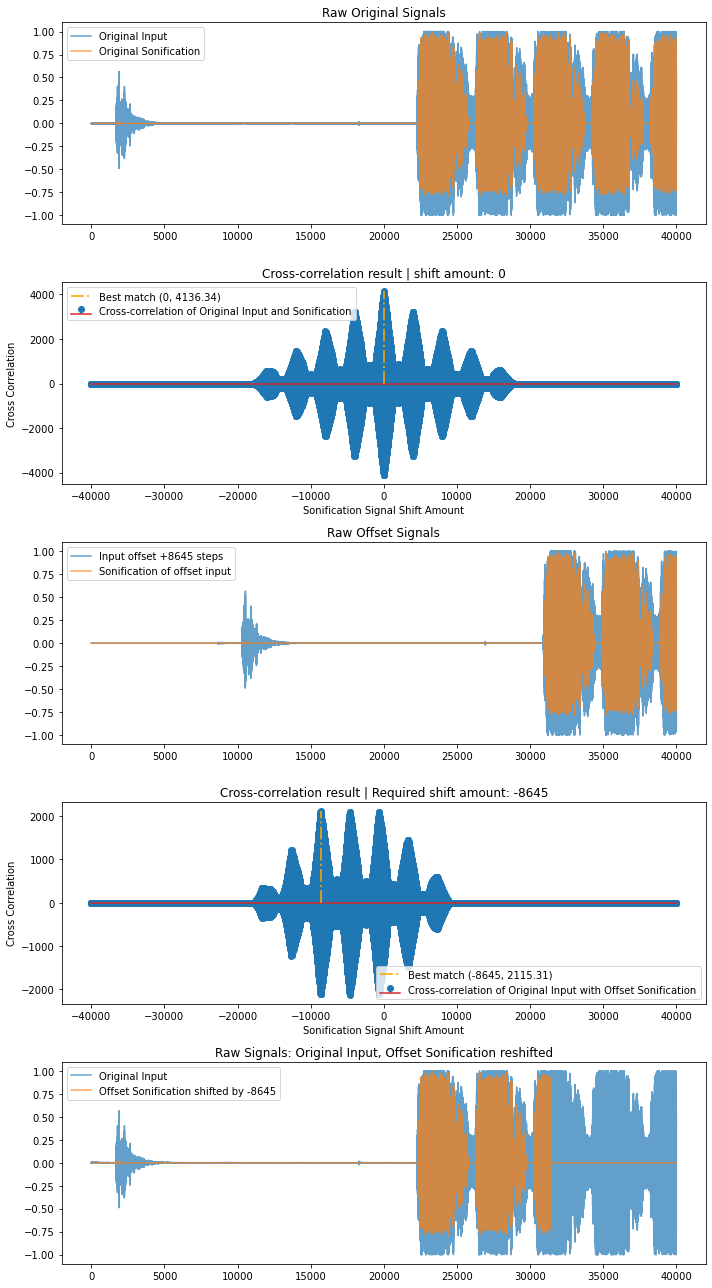

In [57]:
plot_invariance(inp_audio, dec_audio, inp_2, vis, offset)